In [1]:
import pandas as pd 
import numpy as np 
import seaborn as sns 
from matplotlib import pyplot as plt 

In [2]:
df_train = pd.read_csv("data/train.csv")
df_test = pd.read_csv("data/test.csv")
df_submission = pd.read_csv("data/sampleSubmission.csv")

### EDA에 따른 Feature Engineering 요약 
- target 값 변환 : $y=e^{log(y)}$
- feature 추가 
  - datetime -> year, month, day, hour, minute, second, weekday 
- feature 제거 
  - testset 에 없는 casual, registered 제거 
  - datetime (날짜 요소들로 변환 했으므로)
  - day, minute, second 제거 
  - windspeed 제거 
- 이상치 제거 
  - weather = 4 제거

## feature engineering

In [31]:
df_train.shape

(10885, 12)

In [3]:
df_train = df_train[df_train["weather"] != 4]

In [4]:
train_test = pd.concat([df_train, df_test], ignore_index=True)
train_test

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0000,3.0,13.0,16.0
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0000,8.0,32.0,40.0
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0000,5.0,27.0,32.0
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0000,3.0,10.0,13.0
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0000,0.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...
17373,2012-12-31 19:00:00,1,0,1,2,10.66,12.880,60,11.0014,NaN,NaN,NaN
17374,2012-12-31 20:00:00,1,0,1,2,10.66,12.880,60,11.0014,NaN,NaN,NaN
17375,2012-12-31 21:00:00,1,0,1,1,10.66,12.880,60,11.0014,NaN,NaN,NaN
17376,2012-12-31 22:00:00,1,0,1,1,10.66,13.635,56,8.9981,NaN,NaN,NaN


In [5]:
train_test["datetime"] = pd.to_datetime(train_test["datetime"])
for attr in ["date", "year", "month", "hour", "weekday"]:
    train_test[attr] = getattr(train_test["datetime"].dt, attr)

In [6]:
drop_features = ["casual", "registered", "datetime", "date", "windspeed", "month"]
train_test = train_test.drop(drop_features, axis=1)

In [7]:
X_train = train_test[~pd.isnull(train_test["count"])]
X_test = train_test[pd.isnull(train_test["count"])]

In [8]:
X_train.shape, X_test.shape

((10885, 11), (6493, 11))

In [9]:
train_test.shape

(17378, 11)

In [10]:
X_train = X_train.drop(columns="count")
X_test = X_test.drop(columns="count")
y = df_train["count"]

### 평가 지표

In [11]:
def rmsle(y_true, y_pred, convertExp=True):
    if convertExp:
        y_true = np.exp(y_true)
        y_pred = np.exp(y_pred)
    
    log_true = np.nan_to_num(np.log(y_true + 1))
    log_pred = np.nan_to_num(np.log(y_pred + 1))    
    
    output = np.sqrt(np.mean((log_true - log_pred) ** 2))
    return output 

### RMSLE (Root Mean Squared Log Error)
$\sqrt{\frac{1}{N}\sum_{i=1}^{N}{(log(y_i+1)-log(\hat{y_i}+1))^2}}$

In [12]:
from sklearn.linear_model import LinearRegression

In [13]:
lr_model = LinearRegression()

In [14]:
log_y = np.log(y)
lr_model.fit(X_train, log_y)

LinearRegression()

In [15]:
y_pred = lr_model.predict(X_train)

In [16]:
rmsle(log_y, y_pred)

1.0204980189305073

## 개선1 : Ridge 모델 

In [ ]:
loss = f 
loss = f + regularization (l2 norm) : ridge ||w||2
loss = f + regularization (l1 norm) : lasso |w|

In [17]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV
from sklearn import metrics

In [18]:
ridge_params = {
    "max_iter" : [3000],
    "alpha" : [0.1, 1, 2, 3, 4, 10, 30, 100, 200, 300, 400, 800, 900, 1000]
}
rmsle_scorer = metrics.make_scorer(rmsle, greater_is_better=False)

In [19]:
ridge = Ridge()
gridsearch_ridge_model = GridSearchCV(estimator=ridge, param_grid=ridge_params, scoring=rmsle_scorer, cv=5)

In [20]:
gridsearch_ridge_model.fit(X_train, log_y)

GridSearchCV(cv=5, estimator=Ridge(),
             param_grid={'alpha': [0.1, 1, 2, 3, 4, 10, 30, 100, 200, 300, 400,
                                   800, 900, 1000],
                         'max_iter': [3000]},
             scoring=make_scorer(rmsle, greater_is_better=False))

In [21]:
gridsearch_ridge_model.best_params_

{'alpha': 0.1, 'max_iter': 3000}

In [22]:
y_pred = gridsearch_ridge_model.best_estimator_.predict(X_train)
rmsle(log_y, y_pred)

1.020497980747181

## 개선2 : Lasso 모델 

In [23]:
from sklearn.linear_model import Lasso

In [24]:
lasso_alpha = 1 / np.array([0.1, 1, 2, 3, 4, 10, 30, 100, 200, 300, 400, 800, 900, 1000])
lasso_params = {
    "max_iter" : [3000],
    "alpha" : lasso_alpha
}
rmsle_scorer = metrics.make_scorer(rmsle, greater_is_better=False)

In [25]:
lasso = Lasso()
gridsearch_lasso_model = GridSearchCV(estimator=lasso, param_grid=lasso_params, scoring=rmsle_scorer, cv=5)
gridsearch_lasso_model.fit(X_train, log_y)
gridsearch_lasso_model.best_params_

{'alpha': 0.00125, 'max_iter': 3000}

In [26]:
y_pred = gridsearch_lasso_model.best_estimator_.predict(X_train)
rmsle(log_y, y_pred)

1.0204881139761979

## 개선3 : RandomForest 모델 

In [27]:
from sklearn.ensemble import RandomForestRegressor

In [28]:
%%time
rf_model = RandomForestRegressor()
rf_params = {
    "random_state" : [42],
    "n_estimators" : [100, 120, 140]
}
gridsearch_rf_model = GridSearchCV(estimator=rf_model, param_grid=rf_params, scoring=rmsle_scorer, cv=5)
gridsearch_rf_model.fit(X_train, log_y)
gridsearch_rf_model.best_params_

CPU times: total: 25.2 s
Wall time: 43.4 s


{'n_estimators': 140, 'random_state': 42}

In [29]:
y_pred = gridsearch_rf_model.best_estimator_.predict(X_train)
rmsle(log_y, y_pred)

0.11265875245404895

Text(0.5, 1.0, 'Predicted Test Data Distribution')

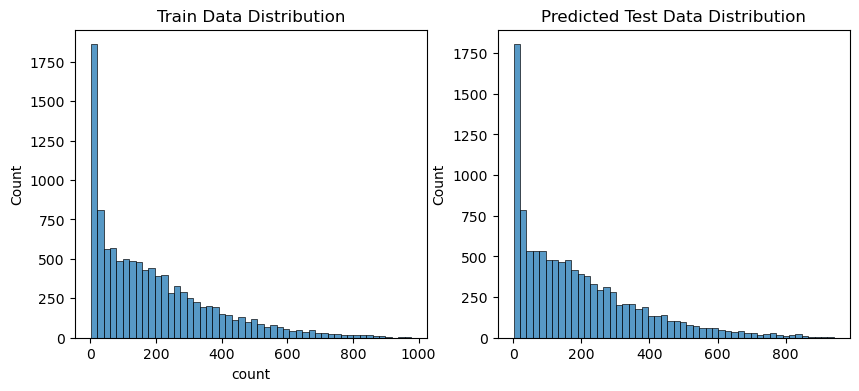

In [30]:
figure, axes = plt.subplots(ncols=2)
figure.set_size_inches(10, 4)
sns.histplot(y, bins=50, ax=axes[0])
axes[0].set_title("Train Data Distribution")
sns.histplot(np.exp(y_pred), bins=50, ax=axes[1])
axes[1].set_title("Predicted Test Data Distribution")